<a href="https://colab.research.google.com/github/faikozcan/MLFraud/blob/main/Wide_DeepWithCustomModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load Dataset

In [ ]:
#https://medium.com/ml-book/train-tf-keras-model-using-feature-coulmn-8de12e65ddec
import numpy as np
import pandas as pd
import requests 
import io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import feature_column


%matplotlib inline
pd.set_option("display.max_rows", 500, "display.max_columns", 15)
pd.options.display.width=None
pd.options.display.max_columns = None

def get_scal(feature):
  def minmax(x):
    mini = train[feature].min()
    maxi = train[feature].max()
    return (x - mini)/(maxi-mini)
  return(minmax)
url="https://raw.githubusercontent.com/faikozcan/MLFraud/main/dataFiles/Fraud_DataWithCountry.csv"
s=requests.get(url).content
#,usecols=["user_id","signup_time","purchase_time","purchase_value","device_id","source","browser","sex","age","ip_address","ip_country","class"]
dfDownloaded=pd.read_csv(io.StringIO(s.decode('utf-8')),sep = ",",usecols=['signup_time','purchase_time','device_id','user_id','age','sex','source','browser','purchase_value','ip_country','class'])
dfDownloaded.rename(columns={'sex': 'gender'}, inplace=True)
dfDownloaded['purchase_time'] = pd.to_datetime(dfDownloaded['purchase_time'])
dfDownloaded['purchase_hour'] = dfDownloaded['purchase_time'].dt.hour

dfDownloaded['signup_time'] = pd.to_datetime(dfDownloaded['signup_time'])
dfDownloaded['day_of_week'] = dfDownloaded['purchase_time'].dt.day_name().astype(str)
dfDownloaded['day_diff_purchase_signup'] = (dfDownloaded['purchase_time'] - dfDownloaded['signup_time']).dt.days
dfDownloaded['same_Day_Purchase']=np.where(dfDownloaded['day_diff_purchase_signup']==0,1,0)
#assign that dict to a column
device_dict = dict(dfDownloaded.device_id.value_counts())
dfDownloaded['device_TranCount'] = [device_dict[d] for d in dfDownloaded.device_id]
#dfDownloaded['first_tran_with_device'] = np.where(dfDownloaded['device_TranCount']==0,1,0) anlamsız oluyor.
dfDownloaded.drop('purchase_time',axis=1,inplace=True)
dfDownloaded.drop('signup_time',axis=1,inplace=True)
dfDownloaded.drop('day_diff_purchase_signup',axis=1,inplace=True)

dfDownloaded.head(4)

,user_id,purchase_value,device_id,source,browser,gender,age,class,ip_country,purchase_hour,day_of_week,same_Day_Purchase,device_TranCount
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,Japan,2,Saturday,0,1
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,United States,1,Monday,1,1
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,United States,18,Thursday,1,12
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,Unknown,13,Monday,0,1


##Balancing Dataset With Oversampling

113334 train examples
18889 validation examples
18889 test examples
Random over-sampling:
1    102830
0    102830
Name: class, dtype: int64
Random over-sampling:
1    17072
0    17072
Name: class, dtype: int64
Examples:
    Total: 205660
    Positive: 102830 (50.00% of total)

Class 0: 102830
Class 1: 102830
Proportion: 1.0 : 1
205660 train examples
34144 validation examples
18889 test examples


0    17059
1     1830
Name: class, dtype: int64

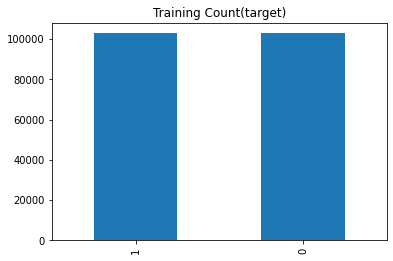

In [ ]:
from sklearn.utils import shuffle

df=dfDownloaded
train=df.sample(frac=0.75,random_state=200) #random state is a seed value
remaining=df.drop(train.index)
test=remaining.sample(frac=0.5,random_state=200) #random state is a seed value
val=remaining.drop(test.index)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')



def oversample(data):
  # Class count
  count_class_0, count_class_1 = data['class'].value_counts()# Class count

  # Random Over Sampling 
  df_class_0 = data[data['class'] == 0]
  df_class_1 = data[data['class'] == 1]
  df_class_1_over = df_class_1.sample(count_class_0,replace=True)
  data = pd.concat([df_class_0,df_class_1_over], axis=0)
  print('Random over-sampling:')
  targetCountsOverSampled=data['class'].value_counts()
  print(targetCountsOverSampled)
  return data




def plotOverSampling(data,row,column,mtitle):
  neg, pos = np.bincount(data['class'])
  total = neg + pos
  print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
      total, pos, 100 * pos / total))
  target_count = data['class'].value_counts()
  print('Class 0:', target_count[0])
  print('Class 1:', target_count[1])
  print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')
  plt.subplot(row,column, 1) # (rows, columns, panel number)
  target_count.plot(kind='bar', title=mtitle)

train=oversample(train)
val=oversample(val)
plt.figure()  # create a plot figure
plotOverSampling(train,1,1,'Training Count(target)')

train = shuffle(train)
val=shuffle(val)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

train.head(20)
val.head(20)
test.head(20)
#val.head(200)

test['class'].value_counts()


## Create Wide And Deep Columns



In [ ]:
from tensorflow import feature_column as fc
deep_columns=[]
wide_columns = []
categorical_columns = {}

#numerical features
num_c = ['purchase_value']
#bucketized numerical features
bucket_c =['age'] 
#categorical features
cat_i_c =['gender','source','browser','day_of_week','purchase_hour'] #indicator columns
cat_e_c =['ip_country'] # embedding column

featureEngineeringActive=1
def DoFeatureEngineering(cat_i_c,num_c):
  return np.concatenate((cat_i_c,['same_Day_Purchase'])), np.concatenate((num_c,['device_TranCount']))
if featureEngineeringActive==1:
  cat_i_c,num_c = DoFeatureEngineering(cat_i_c,num_c)

for header in num_c:
  scal_input_fn = get_scal(header)
  deep_columns.append(fc.numeric_column(header, normalizer_fn=scal_input_fn))
  


age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[20,30, 40,50, 60, 100])
deep_columns.append(age_buckets)

#embedding columns
for feature_name in cat_e_c:
  vocabulary = df[feature_name].unique()
  cat_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  embeding = fc.embedding_column(cat_c, dimension=4)
  deep_columns.append(embeding)

#indicator columns
for feature_name in cat_i_c:
  vocabulary = df[feature_name].unique()
  cat_c = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary)
  categorical_columns[feature_name]=cat_c
  one_hot = fc.indicator_column(cat_c)
  deep_columns.append(one_hot)

# deviceIdCol=fc.categorical_column_with_hash_bucket('device_id',141000)
# wide_columns.append(fc.indicator_column(deviceIdCol))
country_vocabulary = df['ip_country'].unique()
countryCol=fc.categorical_column_with_vocabulary_list('ip_country',country_vocabulary)
wide_columns.append(fc.indicator_column(countryCol))
#crossed columns
#vocabularyGender = df['sex'].unique()
#gender =fc.categorical_column_with_vocabulary_list('sex', vocabularyGender) 
#crossed_feature = fc.crossed_column([age_buckets, gender], hash_bucket_size=18)
#crossed_feature = fc.indicator_column(crossed_feature)
#wide_columns.append(crossed_feature)

# userid_X_source = fc.crossed_column(['user_id', 'source'], hash_bucket_size=400000)
# crossed_feature1 = fc.indicator_column(userid_X_source)
# wide_columns.append(crossed_feature1)

deviceId_X_source = fc.crossed_column(['device_id', 'source'], hash_bucket_size=450000)
crossed_feature2 = fc.indicator_column(deviceId_X_source)
wide_columns.append(crossed_feature2)

print(wide_columns,deep_columns)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='ip_country', vocabulary_list=('Japan', 'United States', 'Unknown', 'Canada', 'China', 'Brazil', 'India', 'Argentina', 'United Kingdom', 'South Africa', 'Germany', 'Mexico', 'Sweden', 'Korea Republic of', 'Peru', 'Portugal', 'Bangladesh', 'France', 'Taiwan; Republic of China (ROC)', 'Russian Federation', 'Belgium', 'Denmark', 'Netherlands', 'Iran (ISLAMIC Republic Of)', 'Spain', 'Gabon', 'Saudi Arabia', 'Hong Kong', 'Georgia', 'Syrian Arab Republic', 'Turkey', 'New Zealand', 'European Union', 'Australia', 'Ukraine', 'Austria', 'Israel', 'Malaysia', 'Greece', 'Italy', 'Norway', 'Poland', 'Venezuela', 'Thailand', 'Chile', 'Morocco', 'Finland', 'Hungary', 'Indonesia', 'Colombia', 'Ecuador', 'Lithuania', 'Switzerland', 'Viet Nam', 'Nigeria', 'Egypt', 'Seychelles', 'Kazakhstan', 'Kenya', 'Moldova Republic of', 'Trinidad and Tobago', 'Qatar', 'Bolivia', 'Bulgaria', 'Romania', 'Croatia (LOCAL Name: Hrvatska)', 'Cyprus', '

## Create Model

In [ ]:
from keras.metrics import Precision, Recall

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('class')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds



batch_size = 32
train_ds = df_to_dataset(train,shuffle=True, batch_size=batch_size)
print(train_ds)
val_ds = df_to_dataset(val, shuffle=True, batch_size=batch_size)


inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') \
          for colname in ['purchase_value','device_TranCount']
}
inputs.update ({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='int64') \
          for colname in ['user_id','age','same_Day_Purchase','purchase_hour']
})
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') \
          for colname in ['day_of_week','browser','source','gender','device_id','ip_country']
})

# To apply L1 and L2 regularization, you can set dnn_optimizer to:
custom_Optimizer=  tf.keras.optimizers.Adam(
    learning_rate=0.01)

def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns)(inputs)
    for numnodes in dnn_hidden_units:
        deep = tf.keras.layers.Dense(numnodes, activation='relu')(deep) 
        deep=tf.keras.layers.Dropout(0.1)(deep)   
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns)(inputs)
    wide=tf.keras.layers.Dropout(0.2)(wide)
    both = tf.keras.layers.concatenate([deep, wide])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer=custom_Optimizer,loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    return model
model = wide_and_deep_classifier(inputs, wide_columns, deep_columns, [8,8])



callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir='logs'
    ),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
]
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=5,
          verbose=1,
          callbacks=callbacks)
model.summary()



<BatchDataset shapes: ({user_id: (None,), purchase_value: (None,), device_id: (None,), source: (None,), browser: (None,), gender: (None,), age: (None,), ip_country: (None,), purchase_hour: (None,), day_of_week: (None,), same_Day_Purchase: (None,), device_TranCount: (None,)}, (None,)), types: ({user_id: tf.int64, purchase_value: tf.int64, device_id: tf.string, source: tf.string, browser: tf.string, gender: tf.string, age: tf.int64, ip_country: tf.string, purchase_hour: tf.int64, day_of_week: tf.string, same_Day_Purchase: tf.int64, device_TranCount: tf.int64}, tf.int64)>
Epoch 1/5
6427/6427 [==============================] - 1317s 204ms/step - loss: 0.4183 - accuracy: 0.7922 - precision_1: 0.9593 - recall_1: 0.6107 - val_loss: 0.4536 - val_accuracy: 0.7709 - val_precision_1: 0.9809 - val_recall_1: 0.5527
Epoch 2/5
6427/6427 [==============================] - 1316s 205ms/step - loss: 0.2194 - accuracy: 0.9358 - precision_1: 0.9801 - recall_1: 0.8903 - val_loss: 0.4992 - val_accuracy: 0.76

##Test Model

In [ ]:
model.save('WideDeepFraudDetectionModel.h5')

In [ ]:


test_ds2 = df_to_dataset(test, shuffle=True, batch_size=batch_size)
print('all test result')
loss, accuracy,precision,recall = model.evaluate(test_ds2,steps=5000)

all test result
5000/5000 [==============================] - 22s 4ms/step - loss: 0.2290 - accuracy: 0.9403 - precision: 0.7560 - recall: 0.5672


In [ ]:
train[train['device_id']=='MFXDGBZUITKBX']
val[val['device_id']=='MFXDGBZUITKBX']
test[test['device_id']=='MFXDGBZUITKBX']

,user_id,purchase_value,device_id,source,browser,gender,age,class,ip_country,purchase_hour,day_of_week,same_Day_Purchase,device_TranCount
